# Семинар 10

## Отбор признаков

Цель этого семинара — продемонстрировать несколько способов оценки важности признаков и их использования для отбора признаков.

In [1]:
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

%matplotlib inline

# Введение

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

Телескопами MAGIC в настоящее время управляют около 165 астрофизиков из 24 организаций и консорциумов из 12 стран. MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<!--
<center><img src="img/magic1.jpg" width="1000"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/magic1.jpg?raw=true" alt="drawing" width="1000"/>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. По фотографиям можно определить тип частицы из космоса: фотон или протон.

<!--
<center><img src="img/shower.jpg" width="500"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/shower.jpg?raw=true" alt="drawing" width="500"/></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Есть два вида параметров изображения: параметры формы и параметры ориентации.

<!--
<center><img src="img/geo.jpg" width="400"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/geo.jpg?raw=true" alt="drawing" width="400"/></center>

## Фотоны vs адроны

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

<!--
<center><img src="img/gamma_p.png" width="600"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/gamma_p.png?raw=true" alt="drawing" width="600"/></center>

# Part 1: Feature importance

### Data preparation

UCI MAGIC dataset: https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

Features description:
- **Length:** continuous # major axis of ellipse [mm]
- **Width:** continuous # minor axis of ellipse [mm]
- **Size:** continuous # 10-log of sum of content of all pixels [in #phot]
- **Conc:** continuous # ratio of sum of two highest pixels over fSize [ratio]
- **Conc1:** continuous # ratio of highest pixel over fSize [ratio]
- **Asym:** continuous # distance from highest pixel to center, projected onto major axis [mm]
- **M3Long:** continuous # 3rd root of third moment along major axis [mm]
- **M3Trans:** continuous # 3rd root of third moment along minor axis [mm]
- **Alpha:** continuous # angle of major axis with vector to origin [deg]
- **Dist:** continuous # distance from origin to center of ellipse [mm]
- **Label:** g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 \
h = hadron (background): 6688

In [2]:
!wget https://raw.githubusercontent.com/hse-ds/ml-hse-nes/main/2022/seminars/seminar08/data/MAGIC/magic04.data

--2025-11-11 02:48:41--  https://raw.githubusercontent.com/hse-ds/ml-hse-nes/main/2022/seminars/seminar08/data/MAGIC/magic04.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [text/plain]
Saving to: ‘magic04.data’

magic04.data        100%[===================>]   1.41M  8.18MB/s    in 0.2s    

2025-11-11 02:48:42 (8.18 MB/s) - ‘magic04.data’ saved [1477391/1477391]



In [3]:
f_names = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv("magic04.data", header=None, names=list(f_names)+["Label"])
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
# prepare a matrix of input features
X = data[f_names].values

# prepare a vector of true labels
y = 1 * (data['Label'].values == "g")

In [5]:
from sklearn.model_selection import train_test_split

# split the data into train and test subsamples to fit and test classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11, stratify=y)

## Gradient Boosting based feature importances

<!--
<center><img src="img/tree.png" width="400"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/tree.png?raw=true" alt="drawing" width="400"/></center>

Let $T(f)$ be the set of all nodes which use feature $f$ to make split. Then, feature importance $Imp(f)$ of $f$:

$$
Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t)
$$

$$
\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c)
$$

where
- $n_{t}$ - number of objects in node $t$;
- $I(t)$ – impurity function (gini, cross-entropy, MSE) value for the node.

Feature importances estimated by each tree in an ensemble are averaged over all trees in this ensemble.

In [6]:
# this function will be used just to plot feature importances

def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()

In [7]:
# import quality metrics and GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

# define a classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)

# fit it using the train subsample
gb.fit(X_train, y_train)

# get predictions for the test subsample
y_test_proba = gb.predict_proba(X_test)[:, 1]

# compute roc auc score on the test
roc_auc_gb = metrics.roc_auc_score(y_test, y_test_proba)
print("Test ROC AUC: ", roc_auc_gb)

Test ROC AUC:  0.9234904921183772


In [8]:
# get feature imporatnces
f_imps_gb = gb.feature_importances_

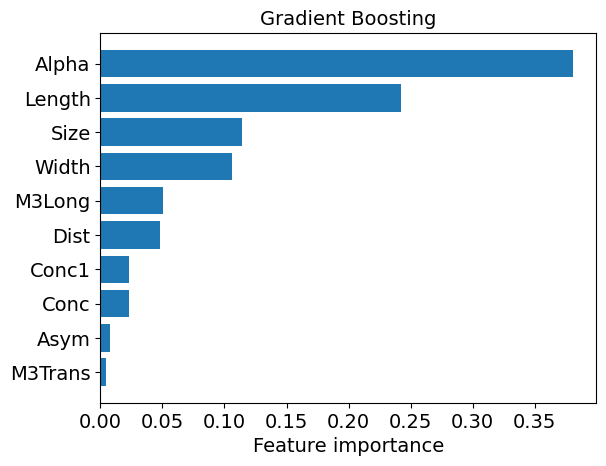

In [9]:
# display the feature importances
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

## Linear model based feature importances

Consider a linear model with regularization ($L_1$ or $L_2$ penalty):

$$
\hat{y}=w_0 + w_1 f_1+ w_2 f_2 + ... + w_k f_k
$$

If features are normalized (have the same ranges), feature importance $Imp(f_i)$ of $f_i$ is equal to:

$$
Imp(f_i) = | w_i |
$$


### Task 1
Estimate feature importacnes using linear model as it is described above.

**Hints:** use `StandardScaler()` to normalize feature values. Also, use `LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=11)` for the linear model. To get values of the model coefficients use `<model>.coef_[0]` method.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_feature_imp_with_lin_mod(X_train, y_train, C=1.0):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_train: numpy.ndarray
        Object features matrix.
    y_train: numpy.array
        Vector of true class labels.
    C: float
        Inverse of regularization strength; must be a positive float.

    Returns:
    --------
    f_imps_lin: numpy.array
        Estimated feature importances.
    """

    # normalize feature values
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_ss = ss.transform(X_train)

    ### BEGIN SOLUTION
    # fit a linear model with regularization
    linclf = LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=11)
    linclf.fit(X_train_ss, y_train)

    # get feature importances
    f_imps_lin = np.abs(linclf.coef_[0])
    ### END SOLUTION

    return f_imps_lin

In [11]:
f_imps_lin = get_feature_imp_with_lin_mod(X_train, y_train, C=1.)
f_imps_lin

array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
       0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])

Expected output:

<center>   
    
```python
array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
       0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])
    
```
    
</center>

In [12]:
### BEGIN HIDDEN TESTS
actual  = f_imps_lin
desired = np.array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
                    0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])
np_testing.assert_almost_equal(actual, desired, decimal=3)
### END HIDDEN TESTS

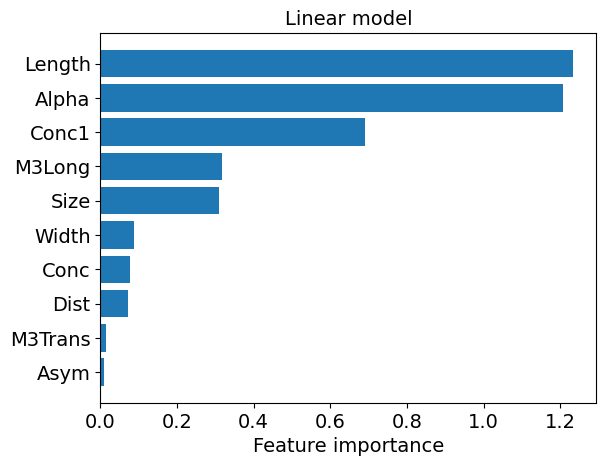

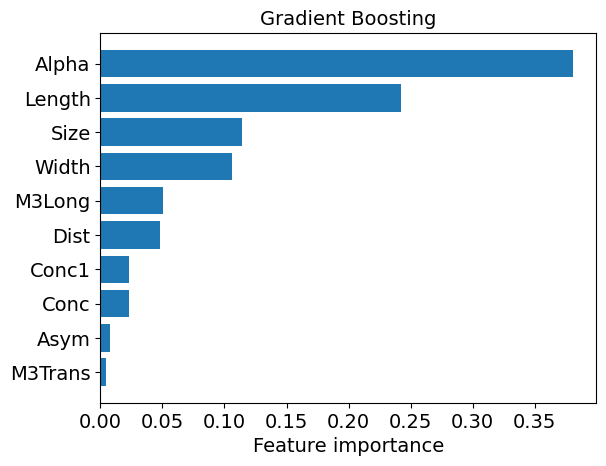

In [13]:
# display the feature importances
plot_feature_importances(f_imps_lin, f_names, "Linear model")
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

Do you have any ideas why the feature importances are so different for these two models? Let's compare quality of the models.

In [14]:
# normalize feature values
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a linear model with regularization
linclf = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, random_state=11)
linclf.fit(X_train_ss, y_train)

# get predictions for the test subsample
y_test_proba = linclf.predict_proba(X_test_ss)[:, 1]

# compute roc auc score on the test
roc_auc_lin = metrics.roc_auc_score(y_test, y_test_proba)

print("Test ROC AUC (GB)    : ", roc_auc_gb)
print("Test ROC AUC (LogReg): ", roc_auc_lin)

Test ROC AUC (GB)    :  0.9234904921183772
Test ROC AUC (LogReg):  0.8367647789157084


## General method

<!--
<center><img src="img/general.png" width="500"></center>
-->
<center><img src="https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar09/img/general.png?raw=true" alt="drawing" width="500"/></center>

Algorithm:
- Train your model
- Calculate quality measure $Q_0$ on the test set
- For a feature $f$:
 - Replace given values with random values from the same distribution (perform random shuffling)
 - Calculate quality measure $Q_f$ on the test set
 - Estimate feature importance: $Imp(f)=Q_0 - Q_f$


### Task 2

Estimate feature importances using general algorithm described above.

**Hint:** to shuffle values of one feature use `numpy.random.RandomState(42).shuffle()`, for an example: `X[:, i] = np.random.RandomState(42).shuffle(X[:, i])`

In [15]:
# define a model that we will use to estimate feature importances
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)

# fit the model on the train sample
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=11)

In [16]:
model.predict_proba(X_test)

array([[0.2978063 , 0.7021937 ],
       [0.9876682 , 0.0123318 ],
       [0.16295925, 0.83704075],
       ...,
       [0.28701715, 0.71298285],
       [0.02913714, 0.97086286],
       [0.4516622 , 0.5483378 ]])

In [17]:
def get_feature_imp_general(X_test, y_test, model):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_test: numpy.ndarray
        Object features matrix.
    y_test: numpy.array
        Vector of true class labels.
    model: object
        A classifier fitted on the train sample

    Returns:
    --------
    f_imps_gen: numpy.array
        Estimated feature importances.
    """

    # define a list for the feature importances
    f_imps_gen = []

    # calculate the base quality value according to the algorithm
    y_test_proba = model.predict_proba(X_test)[:, 1]
    q_0 = metrics.roc_auc_score(y_test, y_test_proba)

    # for each feature in the sample estimate its importance
    for i in range(X_test.shape[1]):

        # do not forget to make a copy of X_test!
        X_test_copy = X_test.copy()

        # shuffle values of the i-th feature
        ### BEGIN SOLUTION
        X_test_copy[:, i] = np.random.RandomState(42).shuffle(X_test_copy[:, i])
        ### END SOLUTION

        # calculate quality metric value
        X_test_copy = np.nan_to_num(X_test_copy)
        y_test_proba = model.predict_proba(X_test_copy)[:, 1]
        q_f = metrics.roc_auc_score(y_test, y_test_proba)

        # estimate importance of the feature
        imp = q_0 - q_f
        f_imps_gen.append(imp)

    return np.array(f_imps_gen)

In [18]:
f_imps_gen = get_feature_imp_general(X_test, y_test, model)
f_imps_gen

array([0.04492045, 0.06596067, 0.08274775, 0.00818297, 0.00349668,
       0.0008778 , 0.00248718, 0.00053567, 0.11451494, 0.09308908])

Expected output (approximately):

<center>   
    
```python
array([0.04537013, 0.06596446, 0.08269023, 0.00817734, 0.00350842,
       0.00091059, 0.00249184, 0.00053674, 0.11450679, 0.09304359])
    
```
    
</center>

In [19]:
### BEGIN HIDDEN TESTS
actual  = f_imps_gen
desired = np.array([0.04537013, 0.06596446, 0.08269023, 0.00817734, 0.00350842,
                    0.00091059, 0.00249184, 0.00053674, 0.11450679, 0.09304359])
np_testing.assert_almost_equal(actual, desired, decimal=2)
### END HIDDEN TESTS

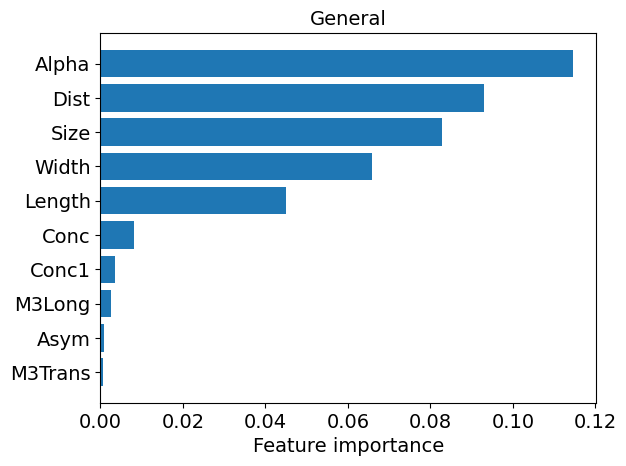

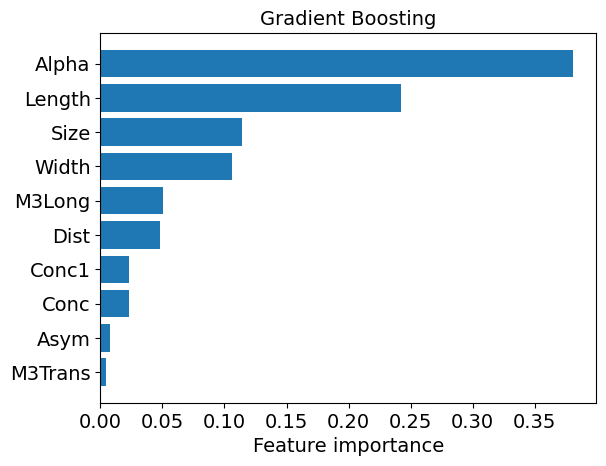

In [20]:
plot_feature_importances(f_imps_gen, f_names, "General")
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

# Part 2: Feature selection

## Recursive feature elimination

- Train a model on the full set of features
- Estimate feature importance (based on the model)
- Remove the least important feature
- Repeat

### Task 3
Implement recursive feature elimination using `model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)` as a model.

**Hint:** use feature importances estimated by the model `model.feature_importances_`.

In [21]:
# make copies for further steps
X_train_curr = X_train.copy()
X_test_curr  = X_test.copy()
f_names_curr = f_names.copy()

# for storing roc auc scores
roc_auc_scores = []

# eliminate feature by feature
for i in range(X.shape[1]):

    print("Features: ", f_names_curr)

    # 1. fit the model using current set of festures
    # 2. get feature importances
    ### BEGIN SOLUTION
    # fit the model using current set of festures
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)
    model.fit(X_train_curr, y_train)

    # get feature importances
    f_imps = model.feature_importances_
    ### END SOLUTION

    # compute roc auc of the model
    y_test_proba = model.predict_proba(X_test_curr)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_test_proba)

    # print and store it
    auc = np.round(auc, 4)
    print("ROC AUC: ", auc)
    roc_auc_scores.append(auc)

    # remove feature with the least importance
    X_train_curr = X_train_curr[:, f_imps > f_imps.min()]
    X_test_curr  = X_test_curr[:, f_imps > f_imps.min()]
    f_names_curr = f_names_curr[f_imps > f_imps.min()]

    print("\n")

print("Output: ", roc_auc_scores)

Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'Asym' 'M3Long' 'M3Trans' 'Alpha'
 'Dist']
ROC AUC:  0.9235


Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'Asym' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9232


Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.923


Features:  ['Length' 'Width' 'Size' 'Conc1' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9218


Features:  ['Length' 'Width' 'Size' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9186


Features:  ['Length' 'Width' 'Size' 'M3Long' 'Alpha']
ROC AUC:  0.9153


Features:  ['Length' 'Width' 'Size' 'Alpha']
ROC AUC:  0.9113


Features:  ['Length' 'Width' 'Alpha']
ROC AUC:  0.8862


Features:  ['Length' 'Alpha']
ROC AUC:  0.8666


Features:  ['Alpha']
ROC AUC:  0.7823


Output:  [np.float64(0.9235), np.float64(0.9232), np.float64(0.923), np.float64(0.9218), np.float64(0.9186), np.float64(0.9153), np.float64(0.9113), np.float64(0.8862), np.float64(0.8666), np.float64(0.7823)]


Expected output:

<center>   
    
```python
[0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]
    
```
    
</center>

In [22]:
### BEGIN HIDDEN TESTS
actual  = roc_auc_scores
desired = [0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]
np_testing.assert_almost_equal(actual, desired, decimal=3)
### END HIDDEN TESTS

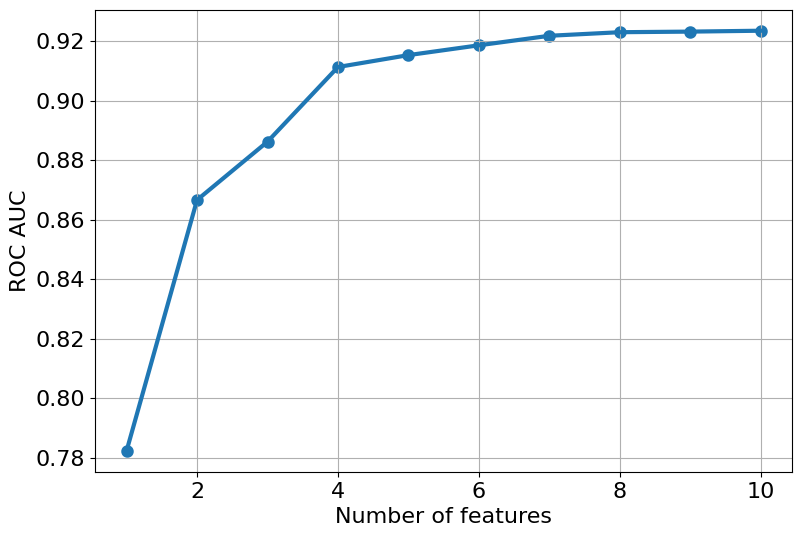

In [23]:
nf = np.arange(1, len(roc_auc_scores)+1)[::-1]
plt.figure(figsize=(9, 6))

plt.plot(nf, roc_auc_scores, linewidth=3)
plt.scatter(nf, roc_auc_scores, linewidth=3)

plt.xlabel("Number of features", size=16)
plt.ylabel("ROC AUC", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
plt.show()

# Часть 3. Метод главных компонент (Principal Component Analysis, PCA)

[Ноутбук Евгения Соколова](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem14_pca_tsne.ipynb)

Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно как-то комбинировать.

__Метод главных компонент__ &mdash; один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи

1. игнорируется целевая переменная;
2. строится линейная комбинация признаков.

П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить не глядя на ответ.

П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

### Теория

Кратко вспомним, что делает этот метод (подробно см. в лекции).

Пусть $X$ &mdash; матрица объекты-признаки, с нулевым средним каждого признака, а $w$ &mdash; некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию вдоль этого направления):

$$
\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$ и процесс повторяется.

## 3.1 PCA на плоскости

Для начала посмотрим на метод PCA на плоскости для того, чтобы лучше понять, как он устроен. Попробуем специально сделать один из признаков более значимым и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного нормального распределения с нулевым математическим ожиданием.

In [24]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[4, 0],
         [0, 1]],
    size=1000
)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент. В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

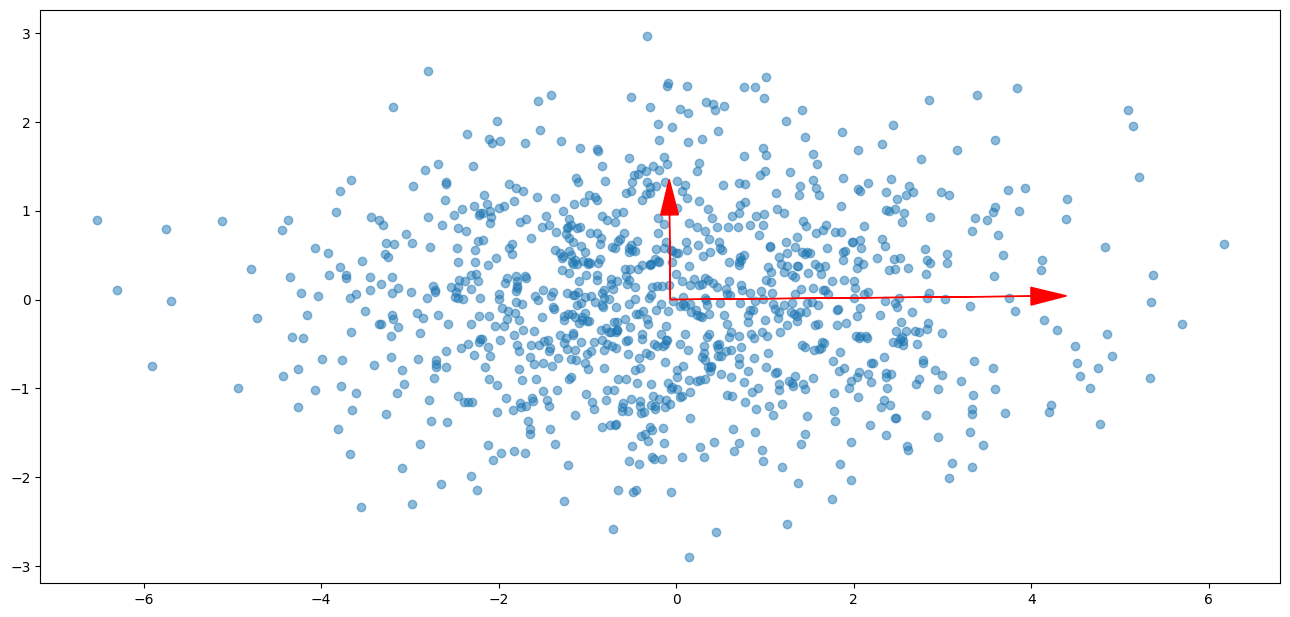

In [25]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)

    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')

    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA все правильно нашел. Но это, конечно, можно было сделать и просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

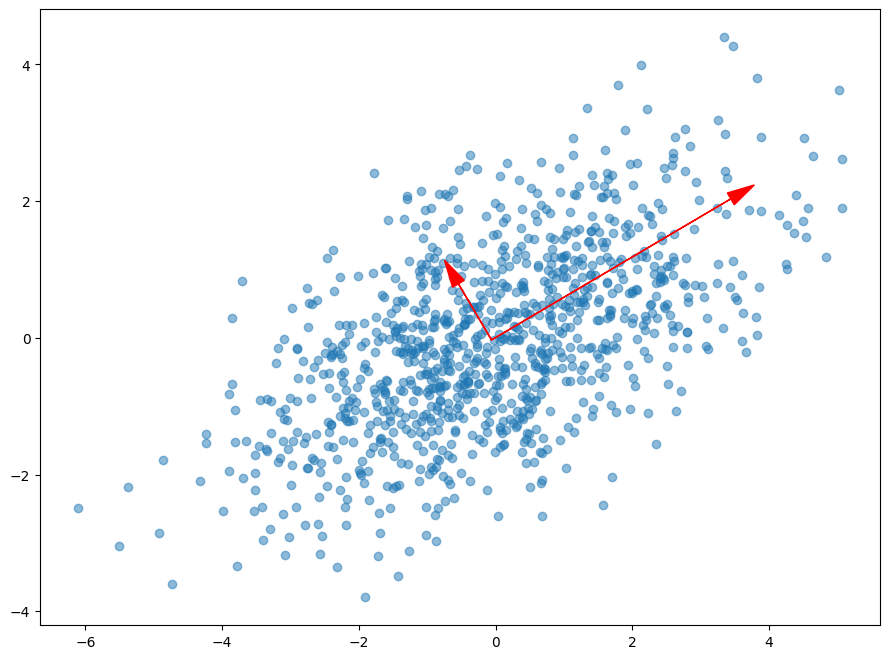

In [26]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки).

**Упражнение:** объясните, почему так произошло.

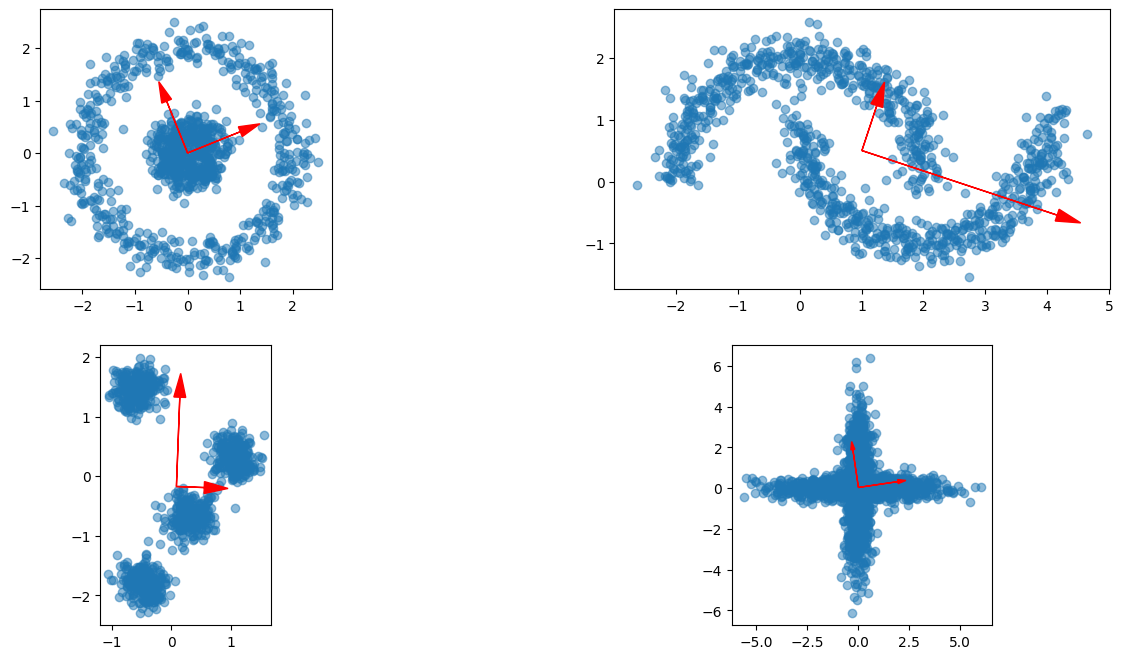

In [27]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)

def make_crossed_blobs():
    horizontal = np.random.multivariate_normal(mean=[0, 0], cov=[[4, 0], [0, 0.1]], size=1000)
    vertical = np.random.multivariate_normal(mean=[0, 0], cov=[[0.1, 0], [0, 4]], size=1000)
    return np.vstack([horizontal, vertical])

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    make_crossed_blobs(),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

## 2.2 Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA. Ниже изображены примеры лиц из базы, и последняя картинка &mdash; это "среднее лицо".

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


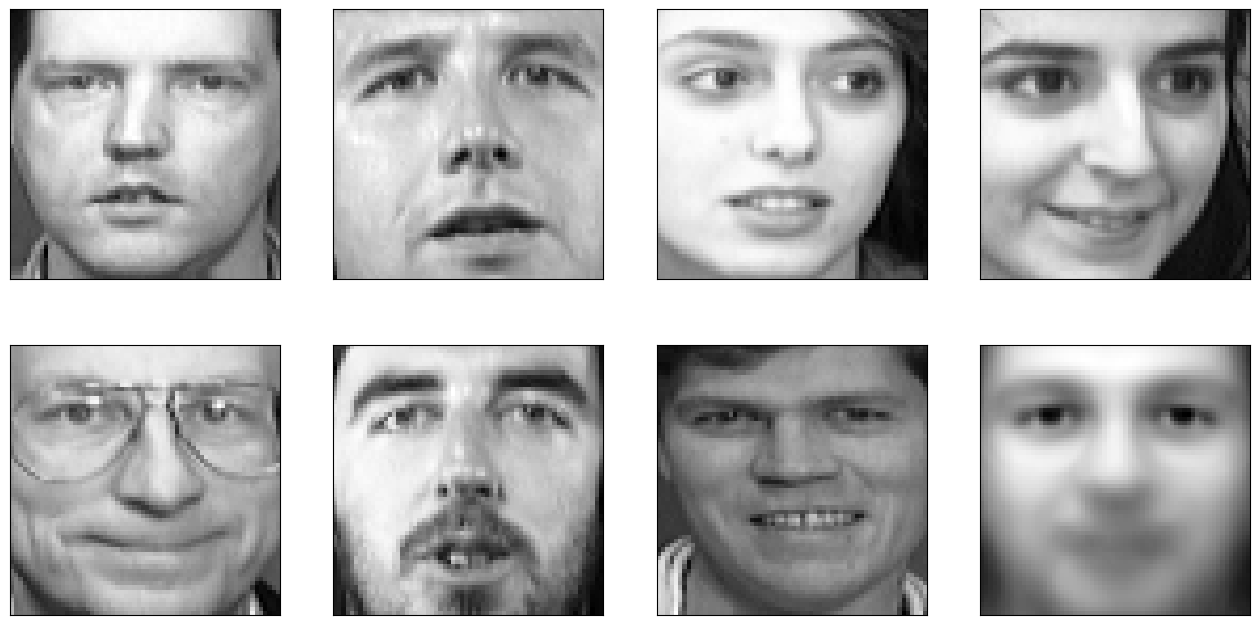

In [28]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)

mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты

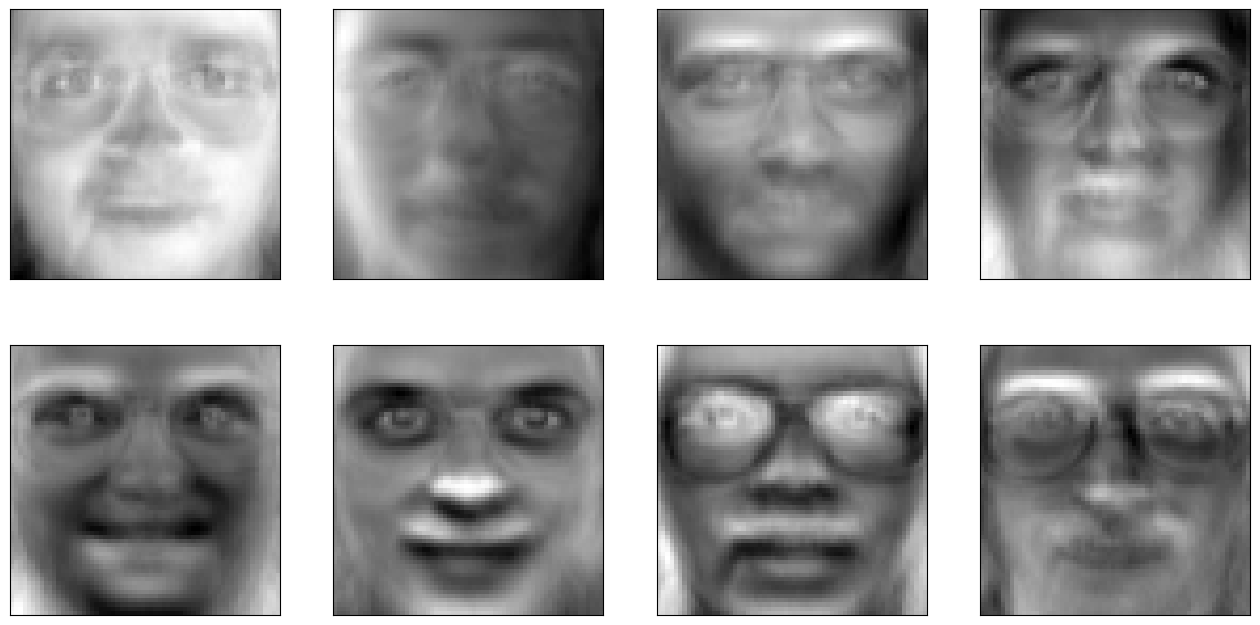

In [29]:
model_pca = PCA()
faces_images -= mean_face  # отнормировали данные к нулевому среднему
model_pca.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

- Во-первых, новые признаки дают более высокое качество классификации.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]}, cv=5
)

In [31]:
%%time
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.825
CPU times: user 5min 13s, sys: 432 ms, total: 5min 14s
Wall time: 5min 18s


In [32]:
%%time
gscv_rf.fit(model_pca.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.915
CPU times: user 2min 4s, sys: 230 ms, total: 2min 4s
Wall time: 2min 12s


На практике можно выбирать столько главных компонент, чтобы оставить $90\%$ дисперсии исходных данных. В данном случае для этого достаточно выделить около $60$ главных компонент, то есть снизить размерность с $4096$ признаков до $60$.

In [33]:
faces_images.shape

(400, 4096)

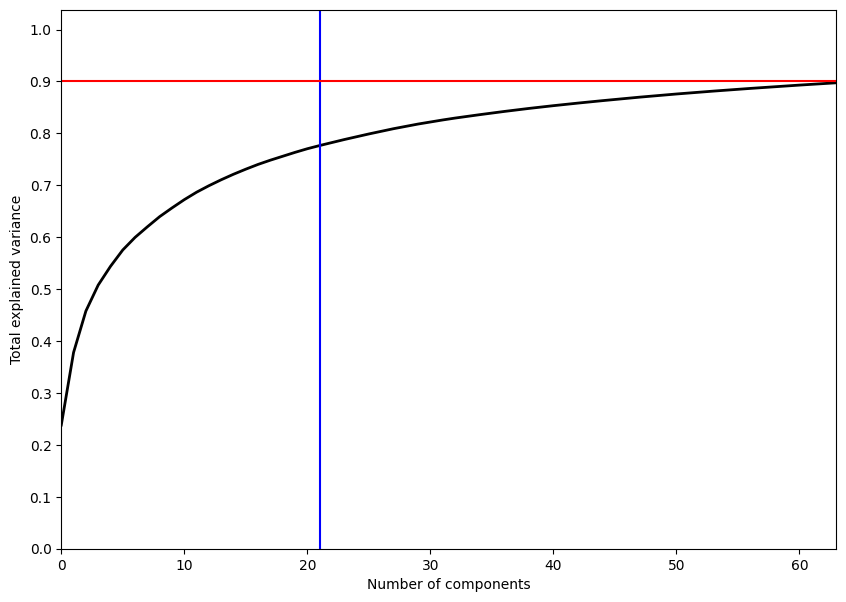

In [34]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

 - Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются в новое пространство, и из него выкидываются самые незначимые признаки. Ниже приведены результаты сжатия в 20 раз.

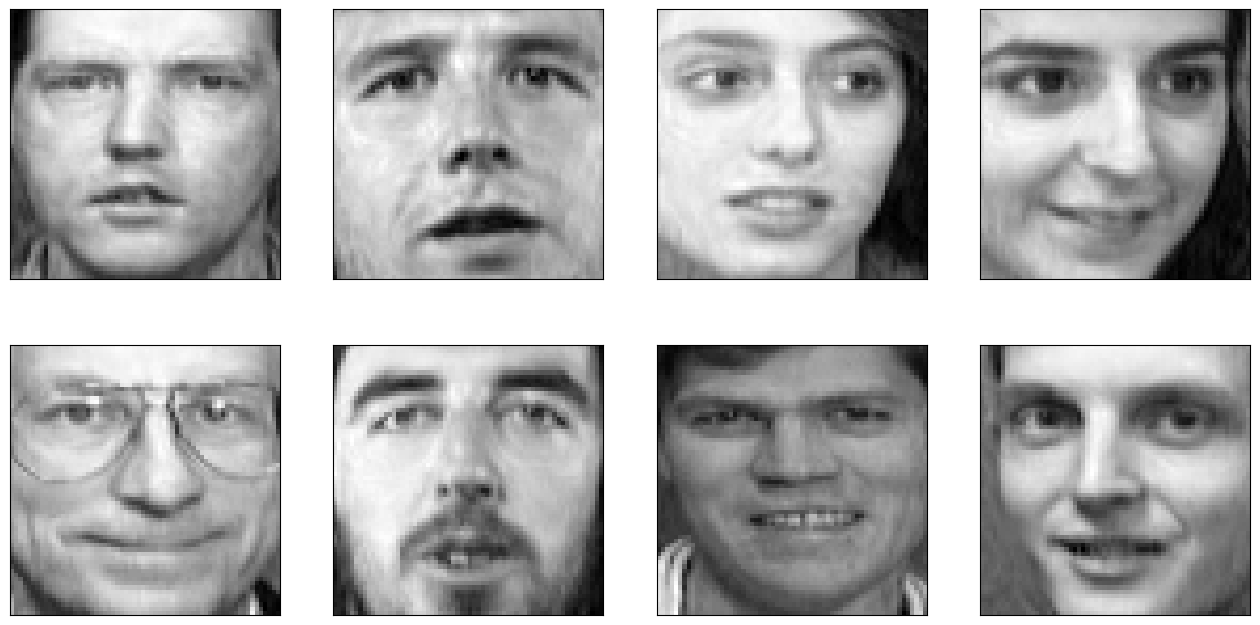

In [35]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    model_pca = PCA(n_components=int(base_size * compress_ratio))
    model_pca.fit(faces_images)

    faces_compressed = model_pca.transform(faces_images)

    # обратное преобразование
    faces_restored = model_pca.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

compress_and_show(0.05)

И даже при сжатии в 50 раз лица остаются узнаваемыми.

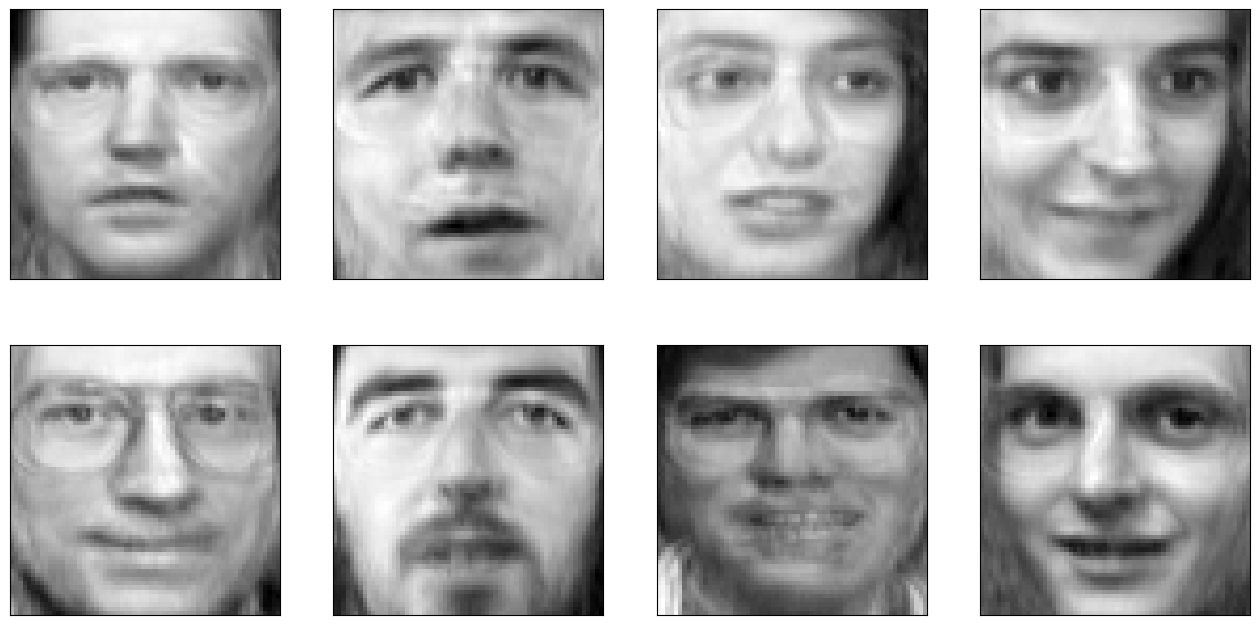

In [36]:
compress_and_show(0.02)